# SLCP Simformer Flow Matching Example
---
This notebook demonstrates conditional flow-matching on the SLCP task using JAX and Flax. 

In [1]:
# Check if running on Colab and install dependencies if needed
try:
    import google.colab
    colab = True
except ImportError:
    colab = False

if colab:
    # Install required packages and clone the repository
    %pip install "gensbi_examples[cuda12] @ git+https://github.com/aurelio-amerio/GenSBI-examples"
    !git clone https://github.com/aurelio-amerio/GenSBI-examples
    %cd GenSBI-examples/examples/sbi-benchmarks/two_moons

In [2]:
# load autoreload extension
%load_ext autoreload
%autoreload 2

In [3]:
import os
# select device

os.environ["JAX_PLATFORMS"] = "cuda" 
# os.environ["JAX_PLATFORMS"] = "cpu" 

## 1. Task & Data Preparation
---
In this section, we define the SLCP task, visualize reference samples, and create the training and validation datasets required for model learning. Batch size and sample count are set for reproducibility and performance.

In [4]:
restore_model=True
train_model=False

In [5]:
import orbax.checkpoint as ocp
# get the current notebook path
notebook_path = os.getcwd()
checkpoint_dir = os.path.join(notebook_path, "checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)

In [6]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from flax import nnx

from numpyro import distributions as dist
import numpy as np


In [7]:
from gensbi.utils.plotting import plot_marginals

In [8]:
from gensbi_examples.tasks import SLCP
task = SLCP()

/home/aure/miniforge3/envs/gensbi/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at grain/proto/execution_summary.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(


In [9]:
# reference posterior for an observation
obs, reference_samples = task.get_reference(num_observation=8)

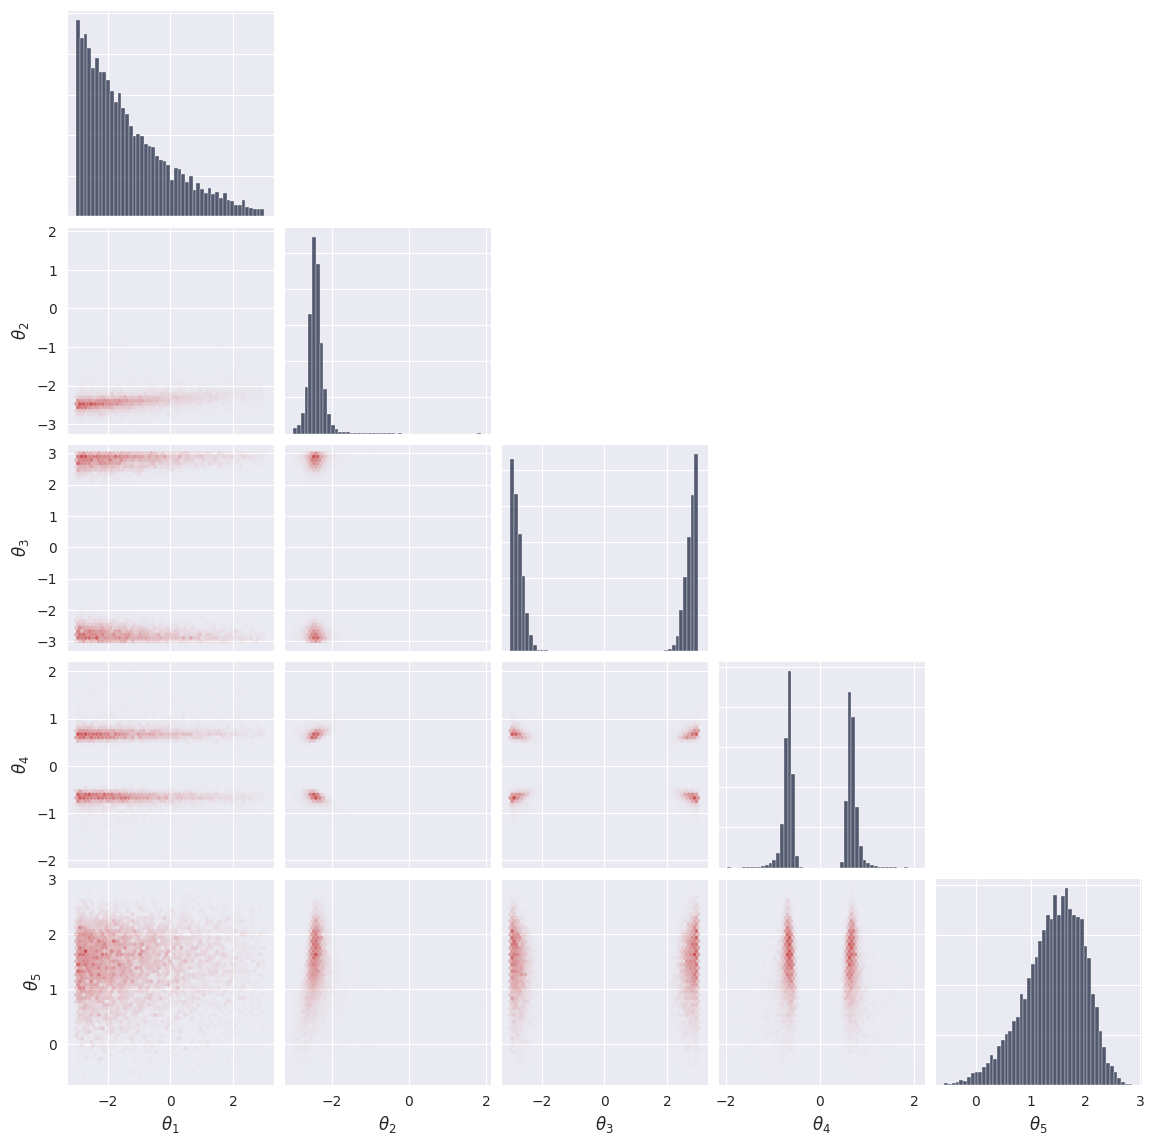

In [10]:
# plot the triangle plot
plot_marginals(np.asarray(reference_samples, dtype=np.float32), gridsize=50, plot_levels=False, backend="seaborn")
plt.show()

In [11]:
# make a dataset
nsamples = int(1e5)

In [ ]:
# Set batch size for training. Larger batch sizes help prevent overfitting, but are limited by available GPU memory.
batch_size = 4096
# Create training and validation datasets using the slcp task object.
train_dataset = task.get_train_dataset(batch_size)
val_dataset = task.get_val_dataset()

# Create iterators for the training and validation datasets.
dataset_iter = iter(train_dataset)
val_dataset_iter = iter(val_dataset)

## 2. Model Configuration & Definition
---
In this section, we load the model and optimizer configuration, set all relevant parameters, and instantiate the Simformer model. Edge masks and marginalization functions are used for flexible inference and posterior estimation.

In [13]:
from gensbi.recipes import SimformerFlowPipeline

In [14]:
import yaml

# Path to the Simformer flow-matching configuration file.
config_path = f"{notebook_path}/config/config_flow_simformer.yaml"

# Load configuration parameters from YAML file.
with open(config_path, "r") as f:
    config = yaml.safe_load(f)

In [15]:
# Extract dimensionality information from the task object.
dim_theta = task.dim_theta  # Number of parameters to infer
dim_data = task.dim_data    # Number of observed data dimensions

dim_joint = task.dim_joint  # Joint dimension (for model input)

In [16]:
pipeline = SimformerFlowPipeline.init_pipeline_from_config(
        train_dataset,
        val_dataset,
        dim_theta,
        dim_data,
        config_path,
        checkpoint_dir,
    )

In [17]:
pipeline.restore_model()

Restored model from checkpoint


## 3. Evaluation & Visualization
---
In this section, we evaluate the trained Simformer model by sampling from the posterior, and comparing results to reference data. We also compute and visualize the unnormalized log probability over a grid to assess model calibration and density estimation. These analyses provide insight into model performance and reliability.

### Section 3.1: Posterior Sampling
---
In this section, we sample from the posterior distribution using the trained model and visualize the results. Posterior samples are generated for a selected observation and compared to reference samples to assess model accuracy.

In [18]:
# we want to do conditional inference. We need an observation for which we want to ocmpute the posterior
def get_samples(idx, nsamples=10_000, use_ema=True, rng=None):
    observation, reference_samples = task.get_reference(idx)
    true_param = jnp.array(task.get_true_parameters(idx))

    if rng is None:
        rng = jax.random.PRNGKey(42)

    time_grid = jnp.linspace(0,1,100)

    samples = pipeline.sample(rng, observation, nsamples, use_ema=use_ema, time_grid=time_grid)
    return samples, true_param, reference_samples

In [30]:
samples, true_param, reference_samples =  get_samples(8, nsamples=int(1e5))

In [31]:
samples.shape

(100, 100000, 5)

### Section 3.2: Visualize Posterior Samples
---
In this section, we plot the posterior samples as a 2D histogram to visualize the learned distribution and compare it to the ground truth.

In [21]:
from gensbi.utils.plotting import plot_marginals

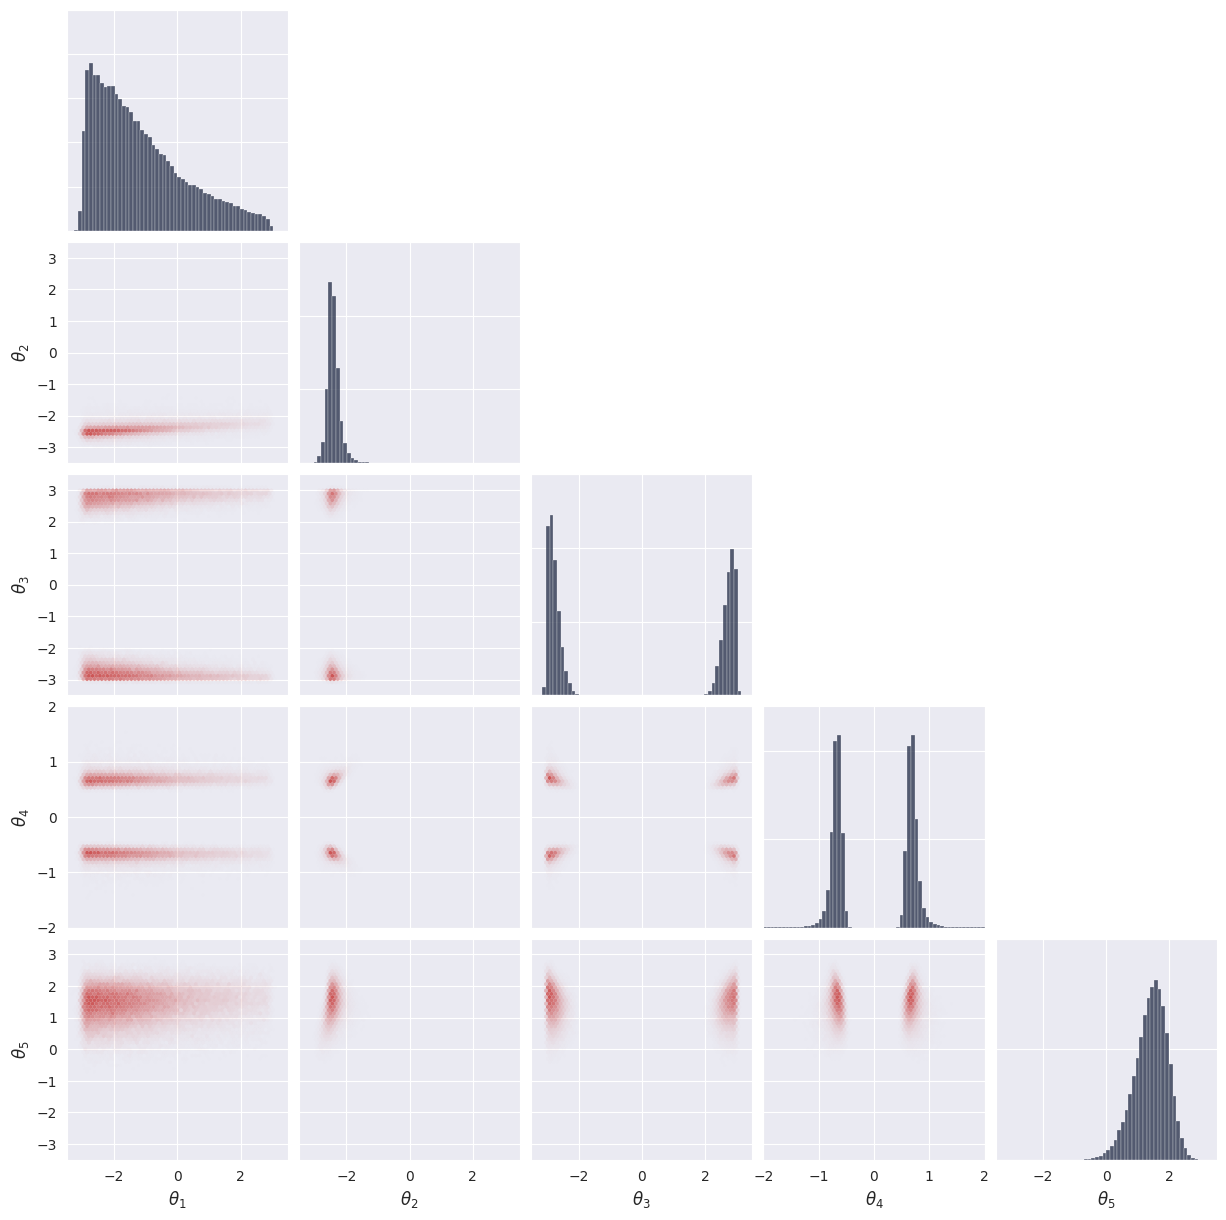

In [43]:
ranges = [(-3.5, 3.5), (-3.5, 3.5), (-3.5, 3.5), (-2, 2), (-3.5, 3.5)]


# check how we set the ranges in the seaborn plot, it seems wrong
fig, axes = plot_marginals(samples[-1], plot_levels=False, backend="seaborn", gridsize=60, range=ranges)
   
axes[0,0].set_ylim(0,0.5)
axes[0,0].set_yticks([0,0.1,0.2,0.3,0.4,0.5])

axes[1,1].set_ylim(0,3)
axes[1,1].set_yticks([0, 1, 2, 3])

axes[2,2].set_ylim(0,1.5)
axes[2,2].set_yticks([0, 0.5, 1, 1.5])

axes[3,3].set_ylim(0,2.5)
axes[3,3].set_yticks([0, 1, 2])

axes[4,4].set_ylim(0,1)
axes[4,4].set_yticks([0, 0.5, 1])

plt.show()

### 3.4. Animations
---
In this section, we create and display animations of posterior samples and density contours over time. These visualizations illustrate the evolution of the learned distribution during the sampling process, providing dynamic insight into model behavior and convergence.

In [23]:
import imageio.v3 as imageio
import io
from tqdm import tqdm

In [36]:
# samples

images = []

for i in tqdm(range(len(samples))):

    ranges = [(-3.5, 3.5), (-3.5, 3.5), (-3.5, 3.5), (-2, 2), (-3.5, 3.5)]

    fig, axes = plot_marginals(
        samples[i],
        plot_levels=False,
        gridsize=60,
        range=ranges,
        backend="seaborn",
    )

    # manually set the ticks to make a prettier plot
   
    axes[0,0].set_ylim(0,0.5)
    axes[0,0].set_yticks([0,0.1,0.2,0.3,0.4,0.5])

    axes[1,1].set_ylim(0,3)
    axes[1,1].set_yticks([0, 1, 2, 3])

    axes[2,2].set_ylim(0,1.5)
    axes[2,2].set_yticks([0, 0.5, 1, 1.5])

    axes[3,3].set_ylim(0,2.5)
    axes[3,3].set_yticks([0, 1, 2])

    axes[4,4].set_ylim(0,1)
    axes[4,4].set_yticks([0, 0.5, 1])

    # axes[1,1].text(0, 1.03, f"t = {(i+1)/len(samples):.2f}", transform=plt.gca().transAxes)

    fig.subplots_adjust(left=0.06, bottom=0.06)

    buf = io.BytesIO()
    plt.savefig(buf, format="jpeg", dpi=100)
    buf.seek(0)
    image = imageio.imread(buf)
    buf.close()
    if i == 0:
        images = []
    images.append(image)
    plt.close()

100%|██████████| 100/100 [01:32<00:00,  1.08it/s]


In [37]:
# repeat the last frame 10 times to make the gif pause at the end
images += [images[-1]] * 20

In [38]:
imageio.imwrite(
    'animated_plot_samples_flux1.gif', 
    images, 
    duration=5000/len(images), 
    loop=0  # 0 means loop indefinitely
)

<img src="./animated_plot_samples_flux1.gif" alt="slcp posterior sampling" width="50%">